# English to Hindi Transliteration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import random

In [48]:
device_gpu

device(type='cuda', index=0)

# Prepare Data

### Alphabets setup

Convert to numerical form (Encode)

### English

In [4]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char:0}
for index, alpha in enumerate(eng_alphabets):
  eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


### Hindi

In [5]:
# Hindi Unicode Hex Range is 2304:2432

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char : 0}
for index, alpha in enumerate(hindi_alphabets):
  hindi_alpha2index[alpha] = index + 1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

Note: de in devanagiri in Hindi, though looks like one character (in Hindi), is actually 2 unicode characters : da and e (in hindi)

# Data Pre-processing helper functions

In [6]:
import re # regular expressions
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters (alphabets and space)
def cleanEnglishVocab(line):
  line = line.replace('-',' ').replace(',',' ').upper() # '-' and ',' act as space
  line = non_eng_letters_regex.sub('', line) # substitute all chars of non_eng_letters_regex present in line by nothing ('')
  return line.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
  # print(line)
  line = line.replace('-',' ').replace(',',' ')
  cleaned_line = ''
  for char in line:
    if char in hindi_alpha2index or char == ' ':
      cleaned_line += char
  return cleaned_line.split() # mistake : gave it one indent more so always returned length 1

# Dataset Loading

XML Parsing

In [12]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET # available in Python

In [13]:
tree = ET.parse('NEWS2012-Ref-EnHi-1000.xml')

In [14]:
root = tree.getroot()
print(root)

<Element 'TransliterationCorpus' at 0x7feeef9389f8>


In [15]:
root.tag

'TransliterationCorpus'

The root tag is named TransliterationCorpus

In [16]:
i = 0
for child in root:
    print(child.tag, child.attrib)
    if i > 5:
      break
    i += 1

Name {'ID': '1'}
Name {'ID': '2'}
Name {'ID': '3'}
Name {'ID': '4'}
Name {'ID': '5'}
Name {'ID': '6'}
Name {'ID': '7'}


The next sub level tags are "Name" tags with "ID" attribute.  
Similar to how a HTML tag div, has an attribute "class" or "id"

In [17]:
i = 0
for elem in root.iter():
    print(elem.tag)
    if i > 11:
      break
    i += 1

TransliterationCorpus
Name
SourceName
TargetName
Name
SourceName
TargetName
Name
SourceName
TargetName
Name
SourceName
TargetName


The above lists the inner elements.  
The inner structure is :  
TransliterationCorpus -> Name -> SourceName at same level as TargetName

In [18]:
# [(ele.tag, ele.attrib) for ele in root.iter("Name")] : prints all attributes of Name tag
# nextelem.tag or nextelem.attrib prints empty braces since this tag has no attributes

i = 0
for nextelem in root.iter("SourceName"):
  print(nextelem.text)
  if i > 11:
    break
  i += 1

Aadhi
Aakash
Aap
Aayasha
Aayee
Abduh
Aberhart
Abey
Abou
Abri
Academy
Accommodation
Acorn


In [19]:
i = 0
for nextelem in root.iter("TargetName"):
  print(nextelem.text)
  if i > 11:
    break
  i += 1

आधी
आकाश
आप
आयशा
आई
अब्दुस
एबरहर्ट
अबेय
अबू
एब्री
अकेडमी
एकेडमी
एकोमडेशन


Thus extracted English and corresponding Hindi from XML.

In [20]:
class TransliterationLoader(Dataset): # extends Dataset, adding features of our own to it
  def __init__(self, filename):
    self.eng_words, self.hindi_words = self.readXMLDataset(filename)
    self.shuffle_indices = list(range(len(self.eng_words)))
    random.shuffle(self.shuffle_indices)
    self.shuffle_start_index = 0

  def __len__(self):
    return len(self.eng_words)

  def __getitem__(self, idx):
    return self.eng_words[idx], self.hindi_words[idx]

  def readXMLDataset(self, filename):
    transliterationCorpus = ET.parse(filename).getroot()
    English_words = []
    Hindi_words = []

    for line in transliterationCorpus:
      wordlist1 = cleanEnglishVocab(line[0].text)
      wordlist2 = cleanHindiVocab(line[1].text)
      # print(wordlist1, '-', wordlist2)

      # Skip noisy data i.e. where number of "words" (not "characters" in each word) is not the same in English and Hindi
      # e.g. English: Stirling Smith Museum And Art Gallery, Hindi: स (4 words in English corresponding to one in Hindi)
      if len(wordlist1) != len(wordlist2):
        print("Skipping: ", line[0].text, '-', line[1].text)
        continue

      # Since each tag may contain more than one word such as : ['STIRLING', 'SMITH', 'MUSEUM', 'AND', 'ART', 'GALLERY'], ['DEOGAN', 'ROAD']
      # ['देवगन', 'रोड']
      for word in wordlist1: 
        English_words.append(word)

      for word in wordlist2: 
        Hindi_words.append(word)

    return English_words, Hindi_words

  def get_random_sample(self):
    return self.__getitem__(np.random.randint(self.__len__()))

  # generalise for Hindi and English (array is the parameter that decides if Hindi or English)
  def get_batch_from_array(self, batch_size, array):
    end = self.shuffle_start_index + batch_size
    batch = []
    if end >= self.__len__():
      batch = [array[i] for i in self.shuffle_indices[0:end%self.__len__()]] # mod if batch size ("end") > the length of eng_words in the corpus we got from the XML file
      end = self.__len__()
    return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]

  def get_batch(self, batch_size, postprocess = True):
    eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
    hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
    self.shuffle_start_index += batch_size + 1
  
    # Reshuffle if 1 epoch is complete
    if self.shuffle_start_index >= self.__len__():
      random.shuffle(self.shuffle_indices)
      self.shuffle_start_index = 0

    return eng_batch, hindi_batch

In [21]:
train_data = TransliterationLoader('NEWS2012-Training-EnHi-13937.xml')
test_data = TransliterationLoader('NEWS2012-Ref-EnHi-1000.xml')

Skipping:  BARHARWA JUNCTION - बरहरवा
Skipping:  STATE BNK TR - स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST - साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII - किंग एडवर्ड
Skipping:  DIBANG VALLEY - दिबंगवैली
Skipping:  ORDER OF VASA - ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD - आज़मनगर
Skipping:  CAPE TOWN - केपटाउन
Skipping:  NEW ZEALAND - न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES - सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND - राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM - केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY - ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA - जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS - नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA - रामालिंगेश्वर
Skipping:  FAKHRUN NISA - फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED - रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR - ओंकार नाथ ठाकुर
Skipping:  OPENTV - ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP - एन्वॉय कम्युनिकेशंस
Skipping:  WAR OF T

# Data Visualisation

In [22]:
print("Train set size: ", len(train_data))
print("Test set size: ", len(test_data))

print("\nSample data from train set:")
for i in range(10):
  eng, hindi = train_data.get_random_sample()
  print(eng + '-' + hindi)

Train set size:  20543
Test set size:  1000

Sample data from train set:
AVENT-एवेंट
RAFTO-रैफ्टो
BLAKEY-ब्लैकी
EXPLOR-एक्सप्लोर
SON-सन
ELPIDA-एल्पिडा
PUSHKIN-पिश्किन
KABHI-कभी
AFTEK-एफ़्टेक
ROCKFORD-रॉकफ़ोर्ड


(Note all english converted to upper case)

# Encoding single words

In [23]:
# OHE for English words (input) - convert word to number (OHE main purpose to convert to number)
def word_rep( word, letter2index, device = 'cpu'):
  rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
  # (number of characters in word, batch in sequence problems, OHE length of each character in vocabulary i.e. 27)
  for letter_index, letter in enumerate(word):
    pos = letter2index[letter]
    rep[letter_index][0][pos] = 1
  pad_pos = letter2index[pad_char]
  # marking the last character in the word as PAD (remember we made word size = actual word size + 1)
  rep[letter_index+1][0][pad_pos] = 1
  return rep


# Just label for Hindi words (output) sice just classification task
def gt_rep(word, letter2index, device = 'cpu'): # ground truth
  gt_rep = torch.zeros([len(word)+1, 1], dtype = torch.long).to(device)
  for letter_index, letter in enumerate(word):
    pos = letter2index[letter]
    gt_rep[letter_index][0] =  pos
  gt_rep[letter_index + 1][0] = letter2index[pad_char]
  return gt_rep

Get one pair of (English word, corresponding Hindi word)

In [24]:
eng, hindi = train_data.get_random_sample()

In [25]:
eng_rep = word_rep(eng, eng_alpha2index)
print(eng, "\n", eng_rep)

ROYAL 
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


8 characters including PAD

In [26]:
hindi_gt = gt_rep(hindi, hindi_alpha2index)
print(hindi, "\n", hindi_gt)

रॉयल 
 tensor([[49],
        [74],
        [48],
        [51],
        [ 0]])


6 characters including PAD (kha, i, da, aa, sha, PAD)

***NOTE: Number of characters in input need not correspond to number of characters in output. That's the reason we use encoder-decoder architecture***

# Network Architecture

Note: 3 letters in input (KHI) correspond to two letters in output (kha, i)  
Similarly 2 letters in input (SH) correspond to one in output (sha)

In such tasks, where output size != input size, need to encode entire input using the encoder part.  
And then process it further using the decoder.

## Encoder-Decoder Using GRU

In [28]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, verbose = False):
    # input size is the size of each input character of the word i.e. 27 (OHE)
    # output size is the size of each output word character i.e. 129 Hindi characters (Label)
    # hidden_size is the number of layers (hyperparameters) of both encoder and decoder RNN cell (needn't be the same, can take 2 parameters for encoder hidden size and decoder hidden size)

    super(Transliteration_EncoderDecoder, self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size

    # size of input to encoder cell is input_size
    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    # size of input to decoder cell is output_size, since the output of the previous timestamp is itself fed to the decoder cell of the current timestamp
    self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)

    # fully connected
    self.h2o = nn.Linear(hidden_size, output_size)
    # softmax since classification
    self.softmax = nn.LogSoftmax(dim=2)

    self.verbose = verbose

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

    # encoder

    """
    Very important:
    Encoder is a single GRU/LSTM cell (here, GRU). Now feeding to it (encoding) can be done in 2 ways when sequence (string) problems.
    i) Feeding one character (vector size : 27), one at a time. And call it as many times as there are alphabets in the word. Thus input to the GRU once is (1,1,27)
    ii) Feeding all the characters at once. In that case, input to GRU is (number of alphabets in word, 1, 27). In one go, computes output of the 6 characters. Internally it happens step wise - i.e. first cell, then output to second cell and so on.
    This is possible, since encoding is a simple computation.
    The dimension of the "out" correspondingly changes.
    """
    out, hidden = self.encoder_rnn_cell(input)

    if self.verbose:
      print('Encoder input', input.shape)
      print('Encoder ouput', out.shape)
      print('Encoder hidden', hidden.shape)

    # decoder
    decoder_state = hidden # the first time the decoder state is set to value of last hidden layer of the encoder
    decoder_input = torch.zeros(1, 1, self.output_size).to(device)
    outputs = []

    if self.verbose:
      print('Decoder state', decoder_state.shape)
      print('Decoder input', decoder_input.shape)

    # unlike encoder, not going to invoke decoder in a single call, but loop through
    for i in range(max_output_chars):

      # the next time the decoder state is the hidden layer's output. Note hidden layer has two outputs. One to right that goes to hidden layer of next cell (timestamp) and the other that is the output of the cell (current character)
      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state) # (input i.e. the previous Hindi char, state i.e. the output of the final hidden layer)

      if self.verbose:
        print('Decoder intermediate output', out.shape)

      # Calculate final output of cell (1,1,129) from hidden output (1,1,256). h2o is defined in the init. A fully connected layer that converts 129 to 256
      out = self.h2o(decoder_state)
      out = self.softmax(out) # softmax
      outputs.append(out.view(1, -1)) # the prediction of the current Hindi character appended to whole output word


      """
      From here, conversion of the output of this layer to a form suitable for next layer
      Instead of passing the softmax directly (1,1,129), we create a one hot encoding of it [ also (1,1,129) since that's the decoder input size ], where the highest softmax value is set as the index. And the rest to zero since the initial few times, we'll be sending the ground truth directly (which is in OHE), instead of the predicted output of the previous decoder cell since that leads to better training during the first few epochs till it learns a bit. After that continue training with the actual predicted output of the previous cell.
      Allows to switch between ground truth (initially, when previous cell gives wrong prediction, at least make learning of next cell proper, else learns wrong since previous one's was wrong) and output of previous cell
      Concept called "Teacher Forcing" : Accelerates training
      """

    
      if self.verbose:
        print('Decoder output', out.shape)
        self.verbose = False
      
      # Finding the argmax, marking that as 1, and the rest as 0
      max_idx = torch.argmax(out, 2, keepdim = True)
      if not ground_truth is None:
        max_idx = ground_truth[i].reshape(1, 1, 1)
      one_hot = torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2, max_idx, 1)


      """
      Output of previous cell goes to input of next timestamp cell. We don't want backpropagation to happen here since becomes too complicated. Only want through hidden layers. Hence detach (don't make note)
      """

      decoder_input = one_hot.detach()

    return outputs

In [29]:
# Chosen number of hidden layers of both encoder and decoder to be 256
net = Transliteration_EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose = True)

In [30]:
def infer(network, word, max_chars, device='cpu'):
  network.eval()
  # network = network.__init__(len(eng_alphabets)+1, 256, len(hindi_alphabets)+1)
  word = word_rep(word, eng_alpha2index)
  # print(word)

  output = network(word, max_chars)
  return output

In [31]:
out = infer(net, "INDIA", 30)

Encoder input torch.Size([6, 1, 27])
Encoder ouput torch.Size([6, 1, 256])
Encoder hidden torch.Size([1, 1, 256])
Decoder state torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 129])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


In [32]:
print(len(out))
for i in range(len(out)):
  print(torch.argmax(out[i]))

30
tensor(11)
tensor(11)
tensor(11)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)
tensor(79)


In [ ]:
list(hindi_alpha2index.values())

In [34]:
print(len(out))
for i in range(len(out)):
  print([list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
[11]
[11]
[11]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]
[79]


In [35]:
print(len(out))
for i in range(len(out)):
  # basically indexing a list . The first "list" is the list to be indexed. The second "list" contains the index inside []
  print(list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
ऊ
ऊ
ऊ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ
ॎ


In [36]:
print(len(out))
for i in range(len(out)):
  print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ऊ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ
torch.Size([1, 129]) ॎ


Completely senseless. (transliteration of INDIA)

# Encoder Decoder with Attention

Not interested in working with the entire hidden state while predicting the first hindi character. Attention will only focus on those hidden states required for that character.

In [37]:
class Transliteration_EncoderDecoder_Attention(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, verbose = False):
    super(Transliteration_EncoderDecoder_Attention, self).__init__()

    self.hidden_size = hidden_size
    self.output_size = output_size

    # Only difference below, decoder is 2*hidden since going to augment
    self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
    self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)

    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 2)

    self.U = nn.Linear(self.hidden_size, self.hidden_size) # U
    self.W = nn.Linear(self.hidden_size, self.hidden_size) # W
    self.attn = nn.Linear(self.hidden_size, 1) # V
    self.out2hidden = nn.Linear(self.output_size, self.hidden_size) # Convert ouptut of decoder to hidden_size too

    self.verbose = verbose

  def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

    # encoder
    """
    Again note difference between encoder_output and hidden:
    Encoder_output is the one coming to the top of the hidden state i.e. the alpha (which is what is considered in the linear combination of the weighted sum)
    While hidden is the one  coming to the right of the hidden state i.e. what goes to the next encoder state.
    Thus output is recorded for each cell i.e. each character (since not redirected anywhere else) while hidden is recorded only once since it is redirected to the next cell each time and hence overwritten
    """
    encoder_outputs, hidden = self.encoder_rnn_cell(input) # input : (#alphabets in word, 1 ,27)
    encoder_outputs = encoder_outputs.view(-1, self.hidden_size)

    if self.verbose:
      print("Encoder hidden", hidden.shape)
      print("Encoder output", encoder_outputs.shape)

    # decoder
    decoder_state = hidden
    decoder_input = torch.zeros(1, 1, self.output_size).to(device)
    
    outputs = []

    # U matrix: multiplying each encoder ouput (alpha). Thus contains the "weight of each input char for each output char".
    # Also note, this matrix is not changed in further code.
    U = self.U(encoder_outputs)

    if self.verbose:
      print("Decoder state", decoder_state.shape)
      print("Decoder intermediate input", decoder_input.shape)
      print("U * Encoder output", U.shape)


    # Decode one by one unlike encoder. Decoding no more as simple as passing through GRU.
    # Find W, Find V
    for i in range(max_output_chars):

      # repeat so that shape matches (as many number of times as chars)
      W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0],1))
      # again linear layer (attn) to calculate Vattn.
      V = self.attn(torch.tanh(U + W))
      # Softmax for finding alpha
      attn_weights = F.softmax(V.view(1, -1), dim=1)

      if self.verbose:
        print("W * Decoder state", W.shape)
        print("V", V.shape)
        print("Attn", attn_weights.shape)

      # once weights found, find weighted sum with encoder outputs (say only one of the alphas is 1, giving attention to only that)
      attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                               encoder_outputs.unsqueeze(0))
      
      # Thus, till here, prepared all the encoder input to the decoder cell (combining encoder output and decoder previous timestamp "hidden state" [not "output"!]). This output called "attention model outcome"


      # Now prepare shape of output of decoder for the next timestamp decoder cell
      embedding = self.out2hidden(decoder_input)
      # Apply linear between the ( previous decoder hidden state + encoder ouputs ) and ( previous decoder output ) so that both the kinds of input are appropriately represented. 
      decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)

      if self.verbose:
        print("Attn LC", attn_applied.shape)
        print("Decoder input", decoder_input.shape)

      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)

      if self.verbose:
        print("Decoder intermediate output", out.shape)

      out = self.h2o(decoder_state)
      out = self.softmax(out)
      outputs.append(out.view(1, -1))

      if self.verbose:
        print('Decoder output', out.shape)
        self.verbose = False

      # Note in all this, U remains same, since only decoder we have to compute each time while U coming from encoder side remains the same throughout

      # Forced teaching
      max_idx = torch.argmax(out, 2, keepdim = True)
      # i.e. if ground truth passed, use that instead of the previous decoder's output
      if not ground_truth is None:
        max_idx = ground_truth[i].reshape(1,1,1)
      one_hot = torch.zeros(out.shape, device = device)
      one_hot.scatter_(2, max_idx, 1)

      # replace the above converted decoder output, to next timestamp's decoder cell input
      # detaching since we don't want backpropagation to flow through these paths
      decoder_input = one_hot.detach()

    return outputs   


In [38]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index), verbose = True)

In [39]:
# Have to feed in the capitals, else throws error since we didn't encode lower case
out = infer(net_attn, "INDIA", 30)

Encoder hidden torch.Size([1, 1, 256])
Encoder output torch.Size([6, 256])
Decoder state torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 129])
U * Encoder output torch.Size([6, 256])
W * Decoder state torch.Size([6, 256])
V torch.Size([6, 1])
Attn torch.Size([1, 6])
Attn LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


Attn is the alpha values [1, 6]

# Training

## Core Trainer

In [43]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):

  net.train().to(device)
  opt.zero_grad() # set gradients to zero. Since the backward() function accumulates gradients, and you don’t want to mix up gradients between minibatches, you have to zero them out at the start of a new minibatch. This is exactly like how a general (additive) accumulator variable is initialized to 0 in code.
  eng_batch, hindi_batch = train_data.get_batch(batch_size)

  total_loss = 0

  # Note, here not passing batches, processing encoder-decoder for one character at a time
  # Can use batching by using "packing"
  for i in range(batch_size):

    input = word_rep(eng_batch[i], eng_alpha2index, device)
    gt = gt_rep(hindi_batch[i], hindi_alpha2index, device)
    outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)

  for index, output in enumerate(outputs):
    loss = criterion(output, gt[index]) / batch_size
    loss.backward(retain_graph = True)
    total_loss += loss

  opt.step()

  """
  https://discuss.pytorch.org/t/what-step-backward-and-zero-grad-do/33301
  Hopefully, you use them in the order : opt.zero_grad(), loss.backward(), opt.step().

    - zero_grad clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
    - loss.backward() computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
    - opt.step() causes the optimizer to take a step based on the gradients of the parameters.

  """

  return total_loss/batch_size

## Train helper

In [44]:
# All hyperparameters
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)

    # Forcing ground truth till only one-third the batches. After that, take from previous cell's predicted
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        # Teacher force only if i<teacher_force_upto
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    # Checkpointing
    torch.save(net, 'model.pt')
    return loss_arr

Loss: Negative Log Likelihood  
Strategy: Stochastic    
Optimizer: Adam    
(Adam = RMSProp + Stochastic, that's why you have the optim.sgd and optim.adam. Optimizers are part of the unit cell, and not the application.)     
Activation function: Sigmoid   
(RNN, LSTM, GRU use this as mentioned in nationality classification)   
Regularisation: Not used here

# Inference

In [49]:
def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, word, 30, device)
    hindi_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        hindi_char = hindi_alphabets[index+1]
        hindi_output += hindi_char
    print(word + ' - ' + hindi_output)
    return hindi_output

# Training without Attention

In [45]:
net = Transliteration_EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 1999 Loss 0.004850402474403381


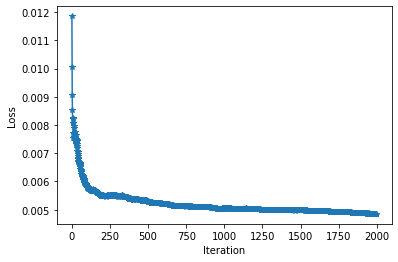

array([0.        , 0.01185805, 0.0100536 , ..., 0.00485027, 0.0048504 ,
       0.00485171])

In [46]:
train_setup(net, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)

In [52]:
out = infer(net, "INDIA", 30)

In [53]:
print(len(out))
for i in range(len(out)):
  print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) क
torch.Size([1, 129]) े
torch.Size([1, 129]) न
torch.Size([1, 129]) ा
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-
torch.Size([1, 129]) -PAD-


# Training with Attention

In [ ]:
net_att = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index), 256, len(hindi_alpha2index))

Iteration 1999 Loss 0.003630336606875062


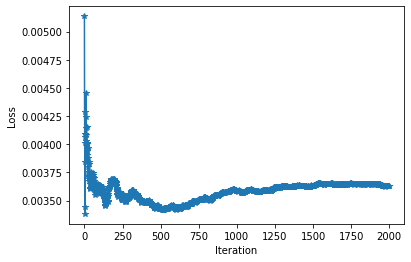

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Transliteration_EncoderDecoder_Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
loss_history = train_setup(net_att, lr=0.005, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)

Parameters in Attention more, but better (lesser) loss than without attention, for same number of batches and epochs. Moreover, loss is still decreasing, so can continue to train.

# Accuracy

In [50]:
def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = gt_rep(hindi, hindi_alpha2index, device)
        outputs = infer(net, eng, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

In [51]:
accuracy = calc_accuracy(net) * 100
accuracy_attn = calc_accuracy(net_att) * 100
print('Accuracy w/o attention ', accuracy)
print('Acurracy with attention', accuracy_attn)

NameError: ignored

# Testing

In [ ]:
out = infer(net_attn, "INDIA", 30)

In [ ]:
print(len(out))
for i in range(len(out)):
  print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) ग़
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ष
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ष
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ष
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ष
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ष
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ष
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ष
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ऀ
torch.Size([1, 129]) ष
torch.Size([1, 129]) ऀ


# Accuracies before and after training

Before:  
Accuracy w/o attention  16.79560800310799  
Acurracy with attention 16.134576257076237  

After: (epochs:2000, lr=0.001)   
Accuracy w/o attention  30.107340159840156   
Acurracy with attention 47.85592518592516


## Todo

1.  Visualise alpha i.e. which characters in input contribute to each character in the output. 
2. Try batching (using packing)  
3. See result of training using inference for few words.